In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
# Fetch LFW dataset with minimum faces per person = 40
lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=0.4)
print(f"Actual shape of the image: {lfw_people.images.shape[1:]}")
# Storing the data
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
print(X.shape)
print(y.shape)
img = X[100].reshape((lfw_people.images.shape[1],lfw_people.images.shape[2]))

Actual shape of the image: (50, 37)
(1867, 1850)
(1867,)


In [3]:
def compute_hog(img):
  # Creating hog features
  img=img.reshape((50,37))
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True)
  return fd, hog_image

In [4]:
X_extracted = []
hog_images = []
for image in X:
    fd, hog_image = compute_hog(image)
    X_extracted.append(fd)
    hog_images.append(hog_image)
X_extracted = np.array(X_extracted)
hog_images = np.array(hog_images)
print("Extracted features has dimensions -", X_extracted.shape)
print(f"Number of features obtained: {X_extracted.shape[1]}")
print(hog_images.shape)

Extracted features has dimensions - (1867, 3168)
Number of features obtained: 3168
(1867, 50, 37)


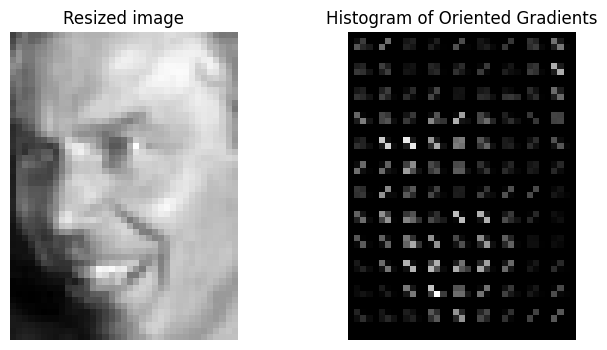

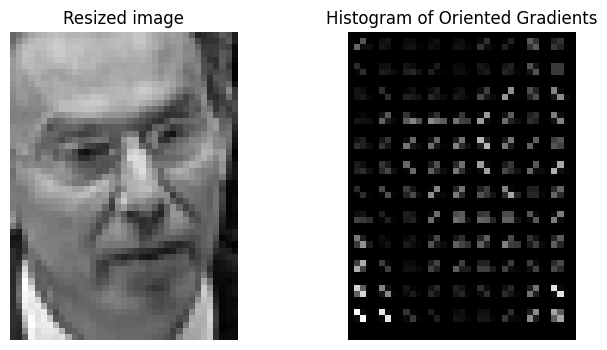

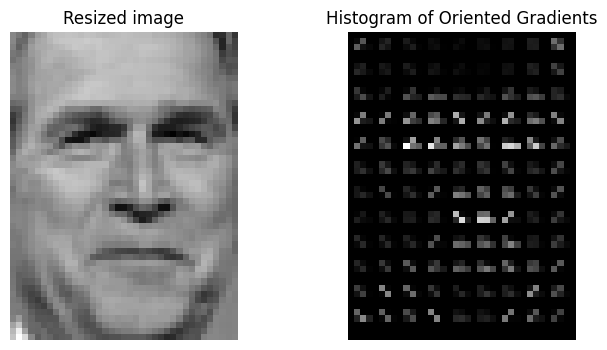

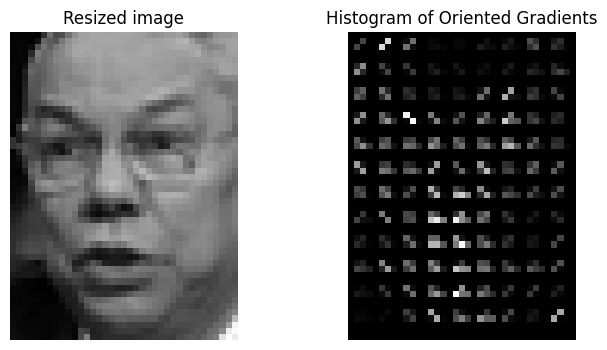

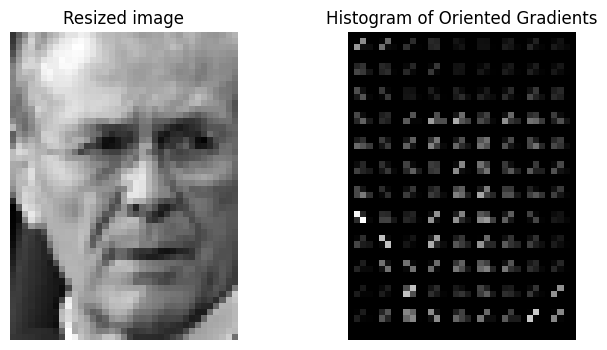

In [5]:
# Visualising HOG image
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(X[i].reshape((50,37)), cmap=plt.cm.gray)
    ax1.set_title('Resized image')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_images[i], in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

## Building a PCA class

In [6]:
class PCAclass:
  def __init__(self,n_components=None):
    # To initialize a PCA object

    # Total number of reduced features in projected data
    self.n_components = n_components
    self.eigenvalues = None
    self.eigenvectors=None
    self.means=None

  def fit(self,X):
    # To fit the model and finding principal components given an array X.
    if self.n_components==None:
      self.n_components=X.shape[0]
    self.means = np.mean(X,axis=0)
    X_mean = X-self.means
    cov_matrix = (X_mean.T @ X_mean)/X_mean.shape[0]
    cov_matrix = (cov_matrix + cov_matrix.T)/2
    self.eigenvalues, self.eigenvectors = np.linalg.eig(cov_matrix)
    self.eigenvalues = np.abs(np.real(self.eigenvalues))
    self.eigenvectors = np.real(self.eigenvectors)

    # (v) Sort eigenvectors based on eigenvalues
    # print(eigenvalues[eigenvalues<0])
    sorted_indices = np.argsort(self.eigenvalues)[::-1]
    self.eigenvalues = self.eigenvalues[sorted_indices]
    self.eigenvectors = self.eigenvectors[:, sorted_indices]
    self.eigenvectors = self.eigenvectors/np.sqrt((np.sum(self.eigenvectors*self.eigenvectors, axis=0)))
    return X @ self.eigenvectors[:,:self.n_components]

  def fit_transform(self,X):
    # returns the given array after projected it along principal components
    return X @ self.eigenvectors[:,:self.n_components]


  def explained_variance(self):
    # returns first 'n_components' number of eigen values in decreasing order
    return self.eigenvalues[:self.n_components]
  def explained_variance_ratio(self):
    # returns ratio of variance captured by first 'n_components' number of eigen values in decreasing order
    return self.eigenvalues[:self.n_components]/np.sum(self.eigenvalues)

  def components(self):
    # returns principal components
    return self.eigenvectors[:,:self.n_components]

  def get_eigenvalues(self):
    # returns all eigen values
    return self.eigenvalues
  def get_eigenvectors(self):
    # returns all eigenvectors
    return self.eigenvectors

### PCA implementation

In [7]:
# To perform splitting of data into train and test sets with ratio 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X_extracted, y, test_size=0.15, stratify=y, random_state=0)
num_components=600   # To reduce the data into  600 features.
# To apply PCA on train data and get principal components.
pca = PCAclass(n_components=num_components)
X_projected = pca.fit(X_train)
X_test_projected = pca.fit_transform(X_test)
principal_components = pca.components()
print(principal_components.shape)
# Convert principal components back to eigen faces.
eigenfaces = (principal_components.T).reshape((principal_components.shape[1],66,48))

# Reconstruct the original data from the extracted features.
X_reconstructed = (X_projected @ (principal_components.T))

(3168, 600)


In [8]:
# X_extracted.shape
principal_components.shape

(3168, 600)

### Explained Variance ratio

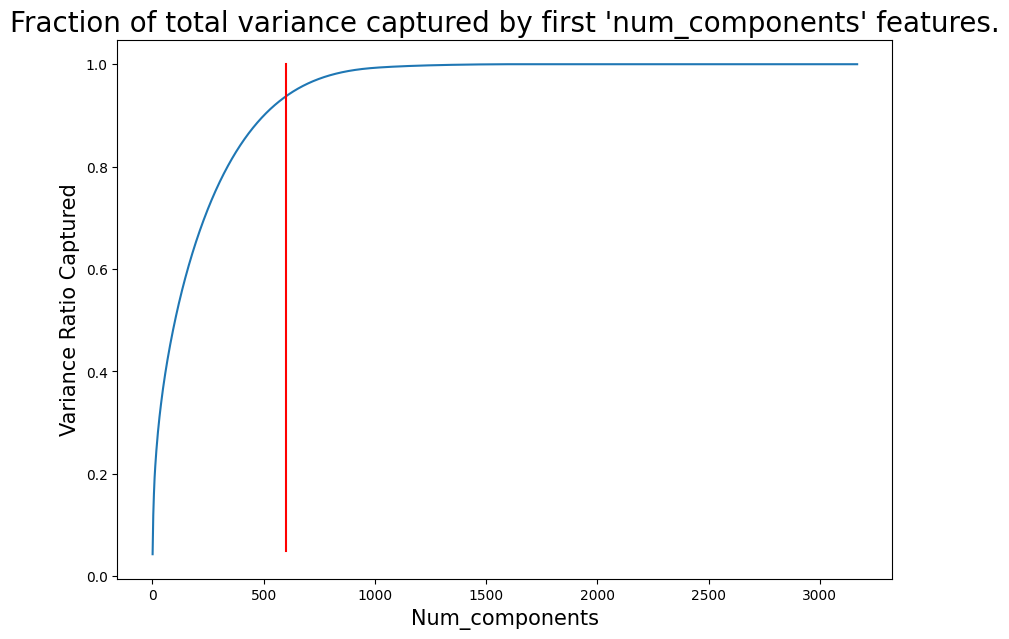

In [9]:
# To plot the graph of total variance captured by first 'num_components' eigen vectors.
x = np.arange(1,X_extracted.shape[1]+1,1)
y = np.cumsum(pca.get_eigenvalues())/np.sum(pca.get_eigenvalues())
plt.figure(figsize=(10,7))
plt.plot(x,y)

x = [num_components,num_components]
y = [0.05,1]
plt.plot(x,y,'r')
plt.title("Fraction of total variance captured by first 'num_components' features.",size=20)
plt.xlabel("Num_components",size=15)
plt.ylabel("Variance Ratio Captured",size=15)
plt.show()

### Eigen Faces

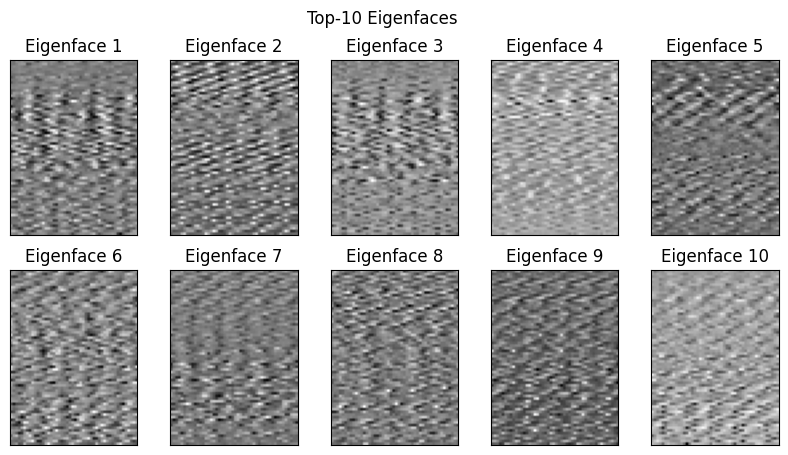

In [10]:
# To plot the first 10 eigenfaces
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.title(f"Eigenface {i + 1}")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("Top-10 Eigenfaces")
plt.show()

# ANN


In [11]:
X_train = X_projected
X_test = X_test_projected
y_train = Y_train
y_test = Y_test

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network architecture
class ANN(nn.Module):
    def __init__(self, input_features, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_features, 100)
        # self.fc2 = nn.Linear(250,70)
        # self.fc3 = nn.Linear(120, 50)
        self.fc4 = nn.Linear(100, num_classes)  # Single output neuron for multiclass classification
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.2)
        # self.softmax = nn.Softmax(dim=1)  # Apply softmax to output

    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        # x = self.relu(self.fc3(x))
        # x = self.dropout(x)
        x = self.fc4(x)
        # x = self.softmax(x)
        return x


# Training Model Function
def train_model(model, optimizer,  train_loader, criterion, num_epochs=100):
  # Set model to train mode
  model.train()

  #training loop
  for epoch in range(num_epochs):
      print(epoch, end=" ")
      for inputs, targets in train_loader:
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

# Testing Model Function
def test_model(model , test_loader):
  # Evaluation
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, targets in test_loader:
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          correct = (predicted == targets).sum().item()
          total = targets.size(0)

  test_accuracy = correct / total
  print(f"\nTest Accuracy: {test_accuracy:.4f}")
  return predicted

In [13]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=X_test.shape[0])

# Instantiate the model
input_features = X_train.shape[1]  # Number of features
num_classes = len(torch.unique(y_train_tensor))  # Number of classes
model = ANN(input_features, num_classes)

# Define loss function and optimizer
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for multiclass classification
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
# optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)  # Example learning rate and momentum values

In [14]:
train_model(model,optimizer,train_loader,criterion,400)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27


Test Accuracy: 0.8612


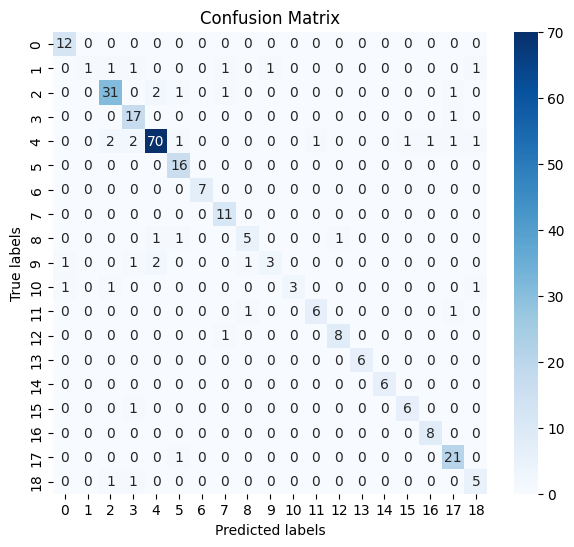

In [15]:
y_pred = test_model(model, test_loader)

## Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
state_dict = model.state_dict()
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = ANN(input_features, num_classes)
new_model.load_state_dict(state_dict)

<All keys matched successfully>